Done in collaboration with Dominic Cordeiro

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Helper Functions

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from zipfile import ZipFile
import csv

root_dir = "/content/gdrive/My Drive/PDF slides/Term 7/50.039 Theory and practice of Deep Learning/HW6"

def findFiles(path): return glob.glob(path)

def get_data():
    category_lines = {}
    all_categories = ['st']
    category_lines['st']=[]
    filterwords=['NEXTEPISODE']
    with open(os.path.join(root_dir,'star_trek_transcripts_all_episodes_f.csv'), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in reader:
            for el in row:
                if (el not in filterwords) and (len(el)>1):
                    # print(el)
                    v=el.strip().replace(';','').replace('\"','')
                    category_lines['st'].append(v)

    n_categories = len(all_categories)
    print(len(all_categories), len(category_lines['st']))
    print('done')
    return category_lines,all_categories



# LSTM model

In [0]:
import torch
import torch.nn as nn
class LSTM_batchy(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.1):
        super(LSTM_batchy, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden_states, temperature=1):
        h0, c0 = hidden_states
        output, (hn, cn) = self.lstm(input, (h0,c0))
        output = self.out(output)
        return output, (hn, cn)

    def initHidden(self, batch_size):
        # return h0, c0
        self.batch_size = batch_size
        return (torch.zeros(self.num_layers*1, self.batch_size, self.hidden_size), torch.zeros(self.num_layers*1, self.batch_size, self.hidden_size))

# Custom dataset and iterator

In [0]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

def inputTensor(line):
    all_letters = string.ascii_letters + "0123456789 .,:!?'[]()/+-="
    n_letters = len(all_letters) + 1
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    all_letters = string.ascii_letters + "0123456789 .,:!?'[]()/+-="
    n_letters = len(all_letters) + 1
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

class startrekLinesDataset(Dataset):
    """ Name Language Dataset """

    def __init__(self, lines_dict, dataset_type, train_ratio, transform=None):
        self.keys = lines_dict.keys()
        self.dataset_type = dataset_type
        self.train_ratio = train_ratio
        self.transform=transform
        self.lines_dict = lines_dict

        self.lines = self.lines_dict['st']

        random.shuffle(self.lines)

        self.split_index = int(len(self.lines)*train_ratio)
        self.test_split_index = int(len(self.lines)*(1+train_ratio)/2)

        self.lines_train, self.lines_val, self.lines_test = self.lines[:self.split_index], self.lines[self.split_index:self.test_split_index], self.lines[self.test_split_index:]
        
        # smaller sample dataset for quick testing
        self.lines_sample = self.lines[:1000]

    def __len__(self):
        if self.dataset_type == "train":
            return len(self.lines_train)
        elif self.dataset_type == "test":
            return len(self.lines_test)
        elif self.dataset_type == "val":
            return len(self.lines_val)
        elif self.dataset_type == "sample":
            return len(self.lines_sample)
        else:
            return None

    def __getitem__(self, idx):
        if self.dataset_type == "train":
            lines = self.lines_train
        elif self.dataset_type == "val":
            lines = self.lines_val
        elif self.dataset_type == "test":
            lines = self.lines_test
        elif self.dataset_type == "sample":
            lines = self.lines_sample
        sample = (inputTensor(lines[idx]), targetTensor(lines[idx]),lines[idx])
        # sample = lines[idx] # print out string
        return sample


class customIterator():
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.initial_batch_size = batch_size
        self.count = 0

    def __iter__(self):
        return self

    def __len__(self):
        return len(self.dataset)

    def __next__(self):
        if self.count == len(self.dataset):
            self.count = 0
            self.batch_size = self.initial_batch_size
            raise StopIteration()

        else:
            if len(self.dataset) - self.count < self.batch_size:
                self.batch_size = len(self.dataset) - self.count
            line_tensors = [self.dataset[self.count+i][0] for i in range(0, self.batch_size)]
            target_tensors = [self.dataset[self.count+i][1] for i in range(0, self.batch_size)]

            self.count += self.batch_size
            
            line_tensors = pad_sequence(line_tensors, padding_value = 0).squeeze(2)
            target_tensors = pad_sequence(target_tensors, padding_value=0)

            return line_tensors, target_tensors

In [0]:
# testing to train character by character.
from tqdm.notebook import tqdm

def get_sample(model, device, start_letter='S', all_letters = string.ascii_letters + "0123456789 .,:!?'[]()/+-="):
    model.eval()
    n_letters = len(all_letters) + 1
    with torch.no_grad():  # no need to track history in sampling
        input_tensor = inputTensor(start_letter)
        hidden, cell = model.initHidden(1)
        hidden, cell = hidden.to(device), cell.to(device)

        output_name = start_letter
        while True:
        
            output, (hidden, cell) = model(input_tensor.to(device), (hidden, cell))
            # add softmax and to output and apply temperature
            distr = torch.softmax(torch.div(torch.flatten(output),0.5),dim=-1)
            sample = torch.multinomial(distr,num_samples=1)

            if sample == n_letters - 1: # EOS
                break
            else:
                letter = all_letters[sample]
                output_name += letter
            input_tensor = inputTensor(letter)

        return output_name

# training on one mini batch of samples, one character at a time.
def train_by_character_batchy(criterion, model, device, optimizer, input_line_tensor, target_line_tensor):
    model.train()
    batch_size = input_line_tensor.shape[1]
    hidden, cell = model.initHidden(batch_size)
    hidden, cell = hidden.to(device), cell.to(device)
    words = {}
    model.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, (hidden, cell) = model(input_line_tensor[i].unsqueeze(0).to(device), (hidden, cell), temperature=0.5) # unsqueeze(0) for seq length of 1
        mask = target_line_tensor[i].nonzero().squeeze(1)
        # print("apply mask:", output.squeeze(0)[mask].shape)
        # print("apply mask to target:",target_line_tensor[i][mask].shape)
        if len(mask) > 0:
            l = criterion(output.squeeze(0)[mask], target_line_tensor[i][mask].to(device))
            loss += l
    loss.backward()
    optimizer.step()

    return loss.item() / input_line_tensor.size(0)

# training for one epoch
def train_epoch(dataloader, criterion, model, device, optimizer, iteration):
    losses = []
    running_count = 0
    output = None
    start_letters = "ABCDEFGHIJKLMNOPRSTUVWZ"
    f = open(os.path.join(root_dir,"5k_output.txt"), "a")
    f.write(f"Epoch {iteration}\n")
    with tqdm(total=len(dataloader)) as progress_bar:
        for i, data in enumerate(dataloader):
            input_tensor, target_tensor = data[0].to(device), data[1].to(device)
            loss = train_by_character_batchy(criterion, model, device, optimizer, input_tensor, target_tensor)
            losses.append(loss)

            running_count += input_tensor.shape[1]
            if running_count > 5000:
                running_count = 0
                for letter in start_letters:
                    name = get_sample(model, device, letter)
                    f.write(name + "\n")
            progress_bar.update(input_tensor.shape[1])
    f.close()

    f = open(os.path.join(root_dir,"output_epoch.txt"),"a")
    f.write(f"Epoch {iteration}\n")
    for letter in start_letters:
        name = get_sample(model, device, letter)
        f.write(str(name) + "\n")
    f.close()
    return np.mean(losses)

# evaluation on one mini batch of samples
def evaluate_per_character(criterion, model, device, optimizer, input_line_tensor, target_line_tensor):
    all_letters = string.ascii_letters + "0123456789 .,:!?'[]()/+-="
    n_letters = len(all_letters) + 1 # Plus EOS marker
    model.eval()
    batch_size = input_line_tensor.shape[1]
    hidden, cell = model.initHidden(batch_size)
    hidden, cell = hidden.to(device), cell.to(device)

    correct = 0
    total = 0
    l = 0
    with torch.no_grad():
        for i in range(input_line_tensor.size(0)):
            output, (hidden, cell) = model(input_line_tensor[i].unsqueeze(0).to(device), (hidden, cell), temperature=0.5) # unsqueeze(0) for seq length of 1
            loss = criterion(output.view(-1, n_letters), target_line_tensor[i])
            topv, topi = output.topk(1, dim=2)
            topi = topi.squeeze(0).squeeze(-1)

            # if target is zero, ignore it.
            mask = target_line_tensor[i].nonzero().squeeze(1)
            
            # apply masking for batch of predictions to remove padded characters
            correct += torch.sum(topi[mask] == target_line_tensor[i][mask])
            total += len(mask) # len of mask is how many non zero elements in the batch
            l += loss.item()
    
    return float(correct)/float(total), l/float(total)

# evaluation on entire dataloader
def evaluate_epoch(dataloader, criterion, model, device, optimizer):
    accuracies = []
    temperature = 0.5
    epoch_eval_loss = []
    with tqdm(total=len(dataloader)) as progress_bar:
        for i, data in enumerate(dataloader):
            input_tensor, target_tensor = data[0].to(device), data[1].to(device)
            acc, loss = evaluate_per_character(criterion, model, device, optimizer, input_tensor, target_tensor) # remove and add elsewhere later on
            accuracies.append(acc)
            epoch_eval_loss.append(loss)
            progress_bar.update(input_tensor.shape[1])
    return np.mean(accuracies), np.mean(epoch_eval_loss)


# training over multiple epochs
def train_eval(trainloader, testloader, criterion, model, device, optimizer, num_epochs):
    # remove old results
    interval_output_path = os.path.join(root_dir, "5k_output.txt")
    epoch_output_path = os.path.join(root_dir, "output_epoch.txt")
    acc_loss_path = os.path.join(root_dir, "acc_loss.txt")

    if os.path.exists(interval_output_path):
        os.remove(interval_output_path)
    if os.path.exists(epoch_output_path):
        os.remove(epoch_output_path)
    if os.path.exists(acc_loss_path):
        os.remove(acc_loss_path)
    
    # lists to store accuracies and losses
    losses = []
    accuracies = []
    val_loss = []
    best_loss = 1000

    # text file to store accuracies and losses
    f = open(acc_loss_path, "a")

    # train and evaluate over epochs
    for i in range(num_epochs):
        print(f"epoch {i}/{num_epochs-1}")
        print("_"*10)

        # training
        loss_per_epoch = train_epoch(trainloader, criterion, model, device, optimizer, i)
        f.write(str(loss_per_epoch) + " ")
        losses.append(loss_per_epoch)

        #evaluation
        acc_per_epoch,loss_eval_epoch = evaluate_epoch(testloader, criterion, model, device, optimizer)
        f.write(str(acc_per_epoch) + " ")
        f.write(str(loss_eval_epoch)+ " \n")
        accuracies.append(acc_per_epoch)
        val_loss.append(loss_eval_epoch)

        if loss_per_epoch < best_loss:
            best_loss = loss_per_epoch
            # save best weights based on loss
            weights_path = os.path.join(root_dir,"startrek_lstm.pt")
            if os.path.exists(weights_path):
                os.remove(weights_path)
            torch.save(model.state_dict(), weights_path)

        print(f"current loss: {loss_per_epoch}\t current acc: {acc_per_epoch}")


    f.close()

    return accuracies, losses, val_loss

In [0]:
import matplotlib.pyplot as plt
def plot(accuracies, losses, loss_eval_epoch):
    plt.plot(accuracies)
    plt.title("Accuracy vs epochs")
    plt.show()

    plt.plot(losses)
    plt.title("training loss vs epochs")
    plt.show()

    plt.plot(loss_eval_epoch)
    plt.title("test loss vs epochs")
    plt.show()

# Main Function

In [0]:
def run():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    cat_lines, all_cats = get_data()
    stdataset_train = startrekLinesDataset(cat_lines, "train", 0.8)
    stdataset_test = startrekLinesDataset(cat_lines, "test", 0.8)
    stdataset_val = startrekLinesDataset(cat_lines, "val", 0.8)
    stdataset_sample = startrekLinesDataset(cat_lines, "sample", 0.8)

    print(len(stdataset_train))
    print(len(stdataset_test))
    print(len(stdataset_test))
    print(len(stdataset_sample))
    
    all_letters = string.ascii_letters + "0123456789 .,:!?'[]()/+-="
    print("all letters", len(all_letters))

    n_letters = len(all_letters) + 1 # Plus EOS marker

    criterion = nn.CrossEntropyLoss()
    model = LSTM_batchy(n_letters, 200, n_letters, 2)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    trainloader = customIterator(stdataset_train, 64)
    testloader = customIterator(stdataset_test, 64)

    # Use a smaller dataset to test
    trainloader = customIterator(stdataset_sample, 64)
    testloader = customIterator(stdataset_sample, 64)

    accuracies, losses, loss_eval_epoch = train_eval(trainloader, testloader, criterion, model, device, optimizer, 20)
    return accuracies, losses, loss_eval_epoch

1 60084
done
48067
6009
6009
1000
all letters 77
epoch 0/19
__________



current loss: 2.536139245802665	 current acc: 0.4235532423174975
epoch 1/19
__________



current loss: 1.8245655165291623	 current acc: 0.5374994043589592
epoch 2/19
__________



current loss: 1.4684110255144125	 current acc: 0.5905749855128335
epoch 3/19
__________



current loss: 1.3357854293808284	 current acc: 0.6082461052571551
epoch 4/19
__________



current loss: 1.266278878067499	 current acc: 0.6214368763093904
epoch 5/19
__________



current loss: 1.2224001475211124	 current acc: 0.6282543254876497
epoch 6/19
__________



current loss: 1.1918607174133065	 current acc: 0.6336495962512031
epoch 7/19
__________



current loss: 1.16729781534448	 current acc: 0.6360070389957382
epoch 8/19
__________



current loss: 1.1486494934157183	 current acc: 0.6395645473762207
epoch 9/19
__________



current loss: 1.1307511232026193	 current acc: 0.6417111190895981
epoch 10/19
__________



current loss: 1.1193067024133538	 current acc: 0.6441943027842247
epoch 11/19
__________



current loss: 1.106915530803977	 current acc: 0.6462787776160793
epoch 12/19
__________



current loss: 1.0977610584330295	 current acc: 0.6477104431651873
epoch 13/19
__________



current loss: 1.087824047468759	 current acc: 0.6494763211816141
epoch 14/19
__________



current loss: 1.0788414524118757	 current acc: 0.648360950138361
epoch 15/19
__________



current loss: 1.0700305751523935	 current acc: 0.6510557143244702
epoch 16/19
__________



current loss: 1.0622104428755619	 current acc: 0.6509823848475957
epoch 17/19
__________



current loss: 1.057068834264776	 current acc: 0.6516843718776155
epoch 18/19
__________



current loss: 1.052852731346565	 current acc: 0.6518380585547339
epoch 19/19
__________



current loss: 1.0468546281510407	 current acc: 0.6533295923726558


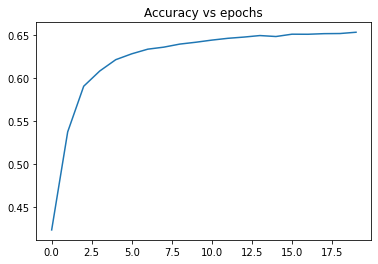

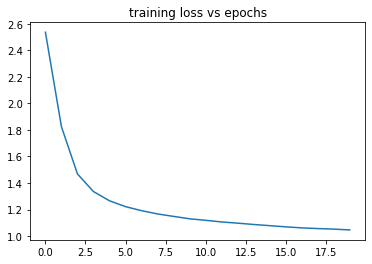

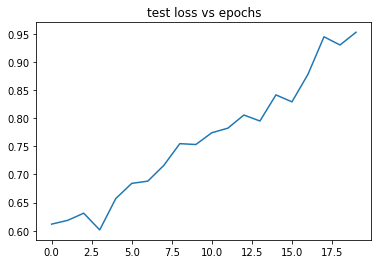

In [0]:
if __name__=="__main__":
    accuracies, losses, loss_eval_epoch = run()
    plot(accuracies, losses, loss_eval_epoch)

# Emmy Winning Quotes
```
TRELANE: I will feel the rest of the other works
WALLACE: He's got to stop the growths
ZALOK: Your wife the millions of it
WESLEY: My life understood.
CHUFTCAPTAIN: I suggest you see them. We could not know the short will be the herbs
```